# Методы улучшения точности точности архитектур в PyTorch
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1vdhFO7AhI_JByG4Nu29FA5jILzpGXI3V#scrollTo=9ic0H8b8qO5z) -->

## Импорт `torch`

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

# from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [6]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', 
                  round(torch.cuda.memory_allocated(cnt_device)/1024**3,1),'GB')
            print('Cached:   ',
                  round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers (CPU cores):',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    


In [7]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.5
Using device: cpu
default data type: torch.float32
available number of workers (CPU cores): 10


# Модификации архитектуры LeNet

В данном уроке мы рассмотрим методы улучшения архитектур на базе `LeNet`, изученной в предыдущем примере. 

Полагаем, что слушатель уже представляет, некоторые изменения, которые мы могли бы внести в архитектуру, чтобы улучшить ее точность. На всякий случай перечислим вносимые изменения:
* замена функции активации от tanh на ReLU;
* замена метода пулинга от среднего на максимальный;
* введение регуляризации, например, методами дроп-аут или батч-нормализации;
* расширение методов аугментации данных.

Напомним, о следующих метода оптимизации.
* С методами аугментации следует быть максимально осторожными и вводить их постенно. 
* Методы регуляризации следует вводить по одному, в ряде случаев может быть так, что в комбинации они будут только снижать общую точность. 
* Если рассматривается батч-нормализация, то она должна быть введена до функции активации, а дроп-аут после.
* В сверточных слоях рекомендуется использование вариантов `BatchNorm2d` или `DropOut2d`.
* Может быть проведен поиск наилучшего оптимизатора, которым не обязательно является, например SGD with moment или Adam, однако последний почти не требует подбора гиперпараметров и может быть лучшую точность по умолчанию.
* Расширенные слои легче обучать чем углубленные, однако, последние увеличивают рецептивное поле - то есть размер воспренимаемого как признак объекта.
* Узкое рецептивное поле способствует более точному выделнию небольших признаков.
* Чем больше размер батча, тем больше может быть обобщающая способность, но ниже точность.
* Использование таких сверток, как каскадная или spatial depthwise позволяет снизить общее число параметров в сети. А также, в таких свертках, как правило, гораздо больше функций активации - то есть нелинейностей, это позволяет выделять больше нелинейных признаков.
* Использование глобального пулинга позволяет снизить общее число параметров по сравнению с flatten layer. При этом, как правило используется `GlobalAveragePooling`.
* В ряде случаев метод `MaxPooling` может быть эквивалентно замещен сверткой с шагом 2.
* Использовании пулинга, как правило, сопроваждается увеличением числа карт признаков.

Реализуем сверточную сеть на базе LeNet с использованем некоторых из приведенных выше особенностей.

В рамках данного примера мы резализуем следующие типы слоев.
* Слой с шагом 2 и ядром 5.
```python
    conv1   = nn.Conv2d(in_channels = 3, out_channels = 6, 
                        kernel_size = 5,  stride = 2,
                        padding     = 2)
```
* Каскадная свертка.
```python
    conv2_1   = nn.Conv2d(in_channels = 6, out_channels = 16, 
                          kernel_size = 3, padding      = 1) 

    conv2_2   = nn.Conv2d(in_channels = 16, out_channels = 16, 
                          kernel_size  = 3, padding      = 1) 

    conv2 = nn.Sequential(conv2_1, nn.ReLU(),
                          conv2_2, nn.BatchNorm2d(16))
```
* Пространственно-разделенная свертка
```python
    conv3_1 = nn.Conv2d(in_channels  = 16,    out_channels = 32, 
                        kernel_size  = (3,1), padding      = 1)

    conv3_2 = nn.Conv2d(in_channels  = 32,    out_channels = 32, 
                        kernel_size  = (1,3), padding      = 1)

    conv3 = nn.Sequential(conv3_1, nn.ReLU(),
                          conv3_2)
```
* Блок с остаточной связью типа "узкое горло"
```python
    conv1x1_1 = nn.Conv2d(in_channels = 32, out_channels = 16, 
                          kernel_size = 1)

    conv3x3  = nn.Conv2d(in_channels = 16, out_channels = 16, 
                         kernel_size = 3,  padding      = 1)

    conv1x1_2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 1) 

    main_block = nn.Sequential(conv1x1_1, nn.BatchNorm2d(16), nn.ReLU(),
                               conv3x3,   nn.BatchNorm2d(16), nn.ReLU(),
                               conv1x1_2, nn.BatchNorm2d(32))
        #-------
        h = self.main_block(x)
        x = x+h
        x = torch.relu(x)
```
* Глубокая разделенная свертка
```python
    depth_conv = nn.Conv2d(in_channels = 32, out_channels = 32,  
                           kernel_size = 3,  groups       = 16,
                           padding     = 1)

    point_conv = nn.Conv2d(in_channels = 32, out_channels = 64, 
                           kernel_size = 1)

    conv5 = nn.Sequential(depth_conv,  nn.BatchNorm2d(32), nn.ReLU(),
                               point_conv)
```
* Батч-нормализация
```python
   bn1 = nn.BatchNorm2d(6)
```
* Макс-Пулинг
```python
   maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
```
* Глобальный средний пулинг
```python
    self.gap = nn.AdaptiveAvgPool2d((1,1))
```

In [8]:
class LeNet(nn.Module):
    
    def __init__(self, in_channels, n_classes):
        super().__init__()
        
        self.in_channels = in_channels
        self.n_classes   = n_classes
        
        # Convolution with stride 2
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels, 
                                 out_channels = 6, 
                                 kernel_size  = 5,
                                 stride       = 2,
                                 padding      = 2,
                                 dilation     = 1)
        
        
        # Cascade Convolution
        conv2_1   = nn.Conv2d(in_channels     = 6, 
                                 out_channels = 16, 
                                 kernel_size  = 3,
                                 padding      = 1) 
        
        conv2_2   = nn.Conv2d(in_channels     = 16, 
                                 out_channels = 16, 
                                 kernel_size  = 3,
                                 padding      = 1) 
        
        self.conv2 = nn.Sequential(conv2_1, 
                                   nn.ReLU(),
                                   conv2_2,
                                   nn.BatchNorm2d(16))
        
        # Spatially-Separable Convolution
        conv3_1 = nn.Conv2d(in_channels  = 16, 
                            out_channels = 32, 
                            kernel_size  = (3,1),
                            padding      = 1)
        
        conv3_2 = nn.Conv2d(in_channels  = 32, 
                            out_channels = 32, 
                            kernel_size  = (1,3),
                            padding      = 1)
        
        self.conv3 = nn.Sequential(conv3_1, 
                                   nn.ReLU(),
                                   conv3_2)    

    
        # Residual bottleneck layer
        conv1x1_1 = nn.Conv2d(in_channels  = 32, 
                              out_channels = 16, 
                              kernel_size  = 1)
        
        conv3x3  = nn.Conv2d(in_channels  = 16, 
                             out_channels = 16, 
                             kernel_size  = 3,
                             padding      = 1)
        
        conv1x1_2 = nn.Conv2d(in_channels  = 16, 
                              out_channels = 32, 
                              kernel_size  = 1) 
        
        self.main_block = nn.Sequential(conv1x1_1,
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(),
                                        conv3x3,
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(),
                                        conv1x1_2,
                                        nn.BatchNorm2d(32))
        
        # Depthwise Separable Convolution
        depth_conv = nn.Conv2d(in_channels  = 32, 
                               out_channels = 32,  
                               kernel_size  = 3, 
                               groups       = 16,
                               padding      = 1)
        
        point_conv = nn.Conv2d(in_channels  = 32, 
                               out_channels = 64, 
                               kernel_size  = 1)
  
        self.conv5 = nn.Sequential(depth_conv, 
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   point_conv)
        
        
        #normalization
        self.bn1 = nn.BatchNorm2d(6)
        
        # pooling
        self.maxpool = nn.MaxPool2d(kernel_size = 2, 
                                    stride      = 2)
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        
        # classification
        self.fc_out = nn.Linear(in_features = 64, 
                                out_features = self.n_classes)

    
    def forward(self, x):
        
        # 1-st layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)        
        
        #2-nd layer
        x = self.conv2(x)         
        x = torch.relu(x)        
        x = self.maxpool(x)
        
        #3-nd layer
        x = self.conv3(x)         
        x = torch.relu(x)               
        x = self.maxpool(x)
        
        #4-th layer
        h = self.main_block(x)
        x = x+h
        x = torch.relu(x)

        
        #5-th layer
        x = self.conv5(x)         
        x = torch.relu(x) 

        # 1-st fc layer
        x = self.gap(x)
        h = torch.flatten(x, 1)
        x = self.fc_out(h)
        
        return x#torch.softmax(x, dim=1)

In [9]:
model = LeNet(3,10)

# from torchsummary import summary
summary(model, input_size = (1,3,32,32))

NameError: name 'summary' is not defined

Посмотрим также карту параметров

In [10]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size()) 
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.0.weight 	 torch.Size([16, 6, 3, 3])
conv2.0.bias 	 torch.Size([16])
conv2.2.weight 	 torch.Size([16, 16, 3, 3])
conv2.2.bias 	 torch.Size([16])
conv2.3.weight 	 torch.Size([16])
conv2.3.bias 	 torch.Size([16])
conv3.0.weight 	 torch.Size([32, 16, 3, 1])
conv3.0.bias 	 torch.Size([32])
conv3.2.weight 	 torch.Size([32, 32, 1, 3])
conv3.2.bias 	 torch.Size([32])
main_block.0.weight 	 torch.Size([16, 32, 1, 1])
main_block.0.bias 	 torch.Size([16])
main_block.1.weight 	 torch.Size([16])
main_block.1.bias 	 torch.Size([16])
main_block.3.weight 	 torch.Size([16, 16, 3, 3])
main_block.3.bias 	 torch.Size([16])
main_block.4.weight 	 torch.Size([16])
main_block.4.bias 	 torch.Size([16])
main_block.6.weight 	 torch.Size([32, 16, 1, 1])
main_block.6.bias 	 torch.Size([32])
main_block.7.weight 	 torch.Size([32])
main_block.7.bias 	 torch.Size([32])
conv5.0.weight 	 torch.Size([32, 2, 3, 3])
conv5.0.bias 	 torch.Size([32])
c

Посмортим на выход сети в данный момент. 

In [11]:
X = torch.randn(1, 3, 32, 32) # Batch Size x Channels x Wide x Height
out = model(X)
print(out.data.cpu().numpy(), '\n max position (Class index):', out.argmax().item())


[[-0.07694669  0.07970402 -0.1199078  -0.00035602 -0.05777796  0.03336902
  -0.08989967  0.07845815  0.22891949 -0.15820855]] 
 max position (Class index): 8


В данном примере мы рассмотрим набор данных CIFAR 10.

Cifar10 - это классический датасет с изображениями, относящимися к 10 классам.
Каждое изображение трех-цветное и имеет размер 32 на 32 пикслея (то есть представляет тензор размером 3х32х32).

Например Cifar10 содержит следующие изображения.

![](https://debuggercafe.com/wp-content/uploads/2019/10/cifar10_plot.png)

Опишим набор преобразований. Мы будем использовать разные преобразования дл тестового и тренировочного наборов данных. В преобразованиях мы используем стандартную нормализацию, о которой речь шла в одном из предыдущих занятий.

In [12]:
mean = torch.tensor([0.485, 0.456, 0.406]) 
std  = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.Resize(36),
                            transforms.RandomRotation(5),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ColorJitter(brightness=0.5, 
                                                   contrast=0.5, 
                                                   saturation=0.5, 
                                                   hue=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean, std=std)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=mean, std=std)
                                     ])

Проведем загрузку набора данных

In [13]:
trainset = torchvision.datasets.CIFAR10(root      = './data',
                                        train     = True,
                                        download  = True,
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data',
                                       train     = False,
                                       download  = True,
                                       transform = test_transforms)


names_classes = trainset.classes
print(names_classes)


Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Выделим часть тренировочного набора данных в валидационный набор. 

In [14]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples



trainset, validset = data.random_split(trainset,
                                       [n_train_examples, 
                                        n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [15]:
print(f'Number of training examples: {len(trainset)}')
print(f'Number of validation examples: {len(validset)}')
print(f'Number of testing examples: {len(testset)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


Теперь создадим загрузчики данных.

In [16]:
BATCH_SIZE = 64


trainloader = data.DataLoader(trainset,
                              shuffle=True,
                              batch_size=BATCH_SIZE)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE)

попробуем визуализировать полученные результаты

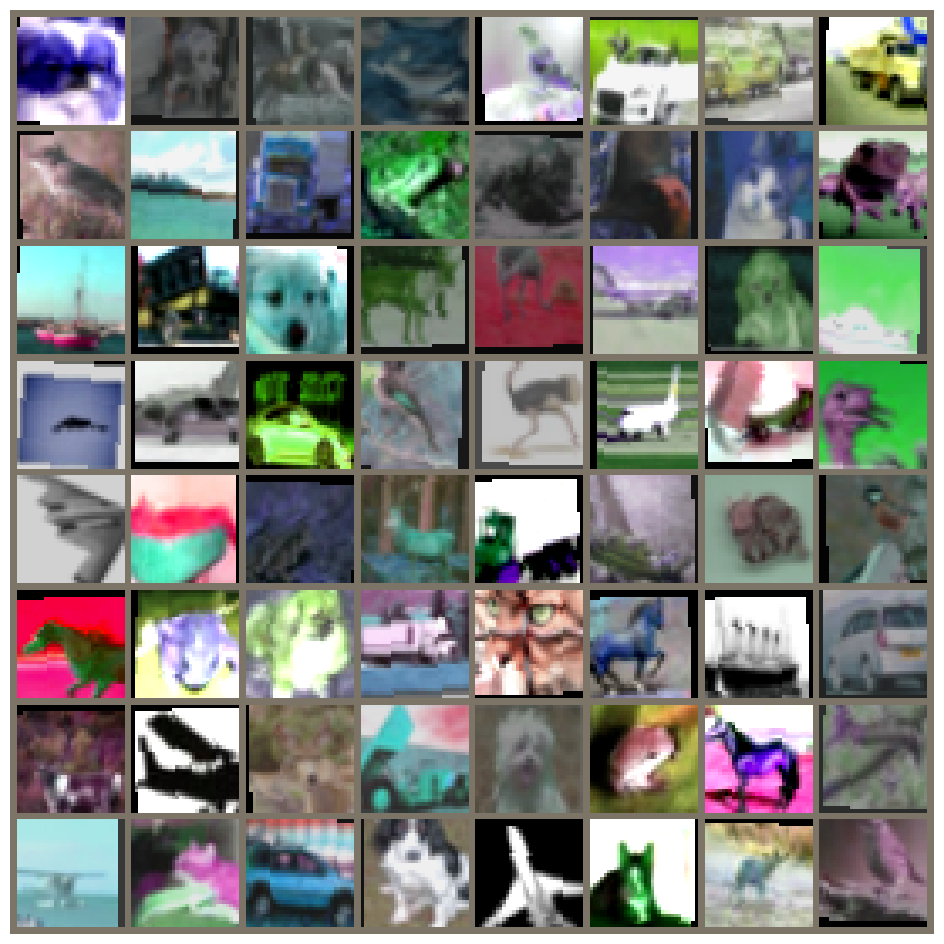

first raw classes   dog   dog horse   cat  bird automobile truck truck
torch.Size([64, 3, 32, 32])


In [17]:
def imshow(images, mean=mean, std=std):
    img = torchvision.utils.make_grid(images).to(device)
    img = img.transpose(2,0).transpose(0,1)
    img = (img * torch.as_tensor(std).to(device) 
               + torch.as_tensor(mean).to(device) )# unnormalize 
    img = img.data.cpu().numpy()

    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

Проведем инициализацию весовых параметров модели. Напомним, что для слоев с ReLU рекомендуется проводить инициализацию Кайменга Ге (Kaiming He) с нормальным распределением, а для слоев с сигмоидом инициализацию Хавьера Глора (Xavier Glort) с равномерным распределением. В нашем случа мы воспользуемся функцией `nn.init.kaiming_normal_`. Также проинциализируем смещения нулями для всех слоев.

In [18]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)
        
model.apply(init_weights);


Для оценки точности работы модели зададим функцию `accuracy`, которая будет подсчитывать число паравильных ответов `correct_cls` и сравнивать с числом ответов всего.

In [19]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

Теперь зададим параметры обучения. Мы будем использовать `CrossEntropyLoss` в качестве функции потерь и оптимизацию методом `Adam` c переменной скоростью обучения (`LR`). Для организации расписания изменения скорости обучения мы воспользуемся подмодулем `torch.optim.lr_scheduler`. В данном примере мы будем использовать ступенчатый метод изменения скорости `StepLR` с периодом ступени 4 эпохи и коэффициентом изменения скорости 0.9

In [20]:
LR = 0.0004
LR_PERIOD = 4
LR_DECAY  = 0.95 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model     = model.to(device)
criterion = criterion.to(device)
metric = accuracy
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size = LR_PERIOD, 
                                            gamma     = LR_DECAY)

Отметим, следующие [практики использования изменяющейся скорости обучения](https://github.com/Devinterview-io/pytorch-interview-questions?tab=readme-ov-file#process-for-implementing-custom-layers):
* __Начните с фиксированной скорости__. Начните обучение с постоянной скорости обучения, чтобы установить базовый уровень и обеспечить начальную сходимость.
* __Настройте параметры планировщика__. Размер шага (`step_size`), гамма (`gamma`) и другие параметры планировщика сильно влияют на производительность модели. Поэкспериментируйте с различными настройками, чтобы найти оптимальный вариант для ваших данных и модели.
* __Следите за потерями и метриками__. Следите за метриками обучения и проверки. Планировщики скорости обучения могут помочь точно настроить модель, адаптируясь к ее изменяющимся потребностям во время обучения.

Когда следует использовать планирование скорости обучения:
* __Разреженные данные__. Для данных с разреженными признаками планирование может помочь модели сосредоточиться на менее распространенных признаках, тем самым повышая производительность.
* __Медленно и быстро обучающиеся признаки__. Не все признаки должны обновляться с одинаковой скоростью. Например, в нейронных сетях весам более ранних слоев может потребоваться больше времени для сходимости. Планирование может помочь ускорить их обновление.
* __Плато потерь__. Когда функция потерь сглаживается, указывая на то, что модель мало чему учится при текущей скорости обучения, планировщик может снизить скорость и вывести модель из колеи.

Перед началом тренировки запишем функцию `train`, которая должна реализовывать тренировку в рамках 1 эпохи. 

Функция будет выбирать все батчи из dataloader в формате `x` - данные и `y` - ответы. Затем для каждого батча будет производится расчет выхода модели `model.forward(x)` и расчет параметров `loss` (потери) и `acc` (точность). 

*Отметим* 
* В режиме тренировки модель должна иметь директиву train  `model.train()`, которая необходима в ряде элементов (например batchnorm), имеющих разное поведения при тренировке и эксплуотации.

* Также отметим, что `dataloader` вызывается при помощи `tqdm` - то есть т.н. *progress bar*.

In [21]:
def train(model, dataloader, optimizer, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Аналогично создадим функцию `evaluate`, которая позволяет оценивать работу модели, например, для валидационного или тестового наборов данных. Особенностями этой функции будут деректива `model.eval()` и `torch.no_grad()`, которые необходимы в режиме тестирования нейронной сети.

In [22]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.inference_mode():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Запишем вспомогательную функцию расчета времени.

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Проведем тренировку на 20 эпохах. В ходе проведения тренировки будем контролровать лучшую эпоху проверяя ее loss на валидации. Каждые 2 эпохи будем выводить результат работы сети в текстовом виде.

In [28]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()
    
    train_loss[epoch], train_acc[epoch] = train(model, 
                                                trainloader, 
                                                optimizer, 
                                                criterion, 
                                                metric,
                                                device)
    
    scheduler.step()
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   validloader, 
                                                   criterion, 
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
        f'| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 39s


TypeError: unsupported format string passed to Tensor.__format__

Теперь попробуем визуализировать процесс обучения.

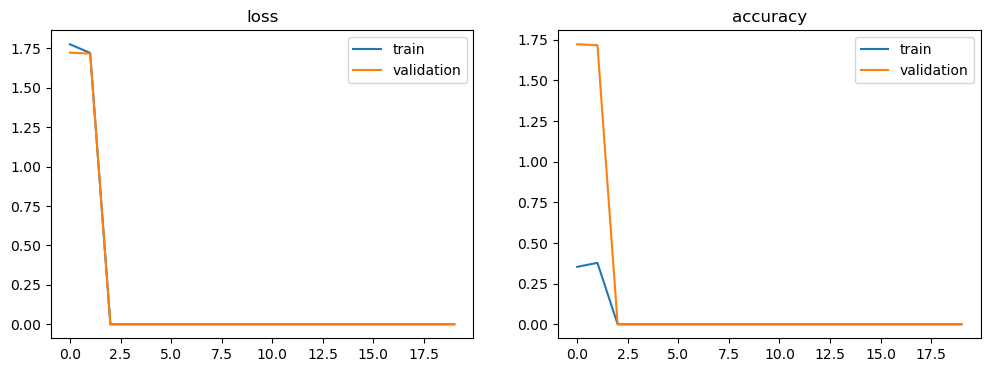

In [29]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss.cpu().numpy(), label = 'train')
    axs[0].plot(valid_loss.cpu().numpy(), label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label = 'train')
    axs[1].plot(valid_acc.cpu().numpy(), label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(train_loss, valid_loss, train_acc, valid_loss )


Проверим точность на лучшей эпохе для тестового набора данных.

In [30]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, testloader, criterion, accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/var/folders/mx/yvyhyfd5039dpqvwzv5cm2h00000gn/T/ipykernel_39264/2945259411.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

best epoch 1: Test Loss: 1.694 | Test Acc: 39.12%


Теперь посмотрим на результаты точности по каждому классу  для тестового набора данных. 

Отметим, что в данной операции мы отдельно подсчитываем точность как отношение `class_correct` к `class_total` по каждому классу `label`, а  также собираем  классы для всех экземпляров `labels` и предсказания `predicts`.

In [31]:
model.eval()

n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

with torch.inference_mode():
    
    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')
        
        cls_pred = torch.argmax(y_pred, dim=1)
        
        c = (cls_pred == y).squeeze() # one-hot vector
        
        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1
    
        labels.append(y)
        predicts.append(cls_pred)
        
labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array
    
for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy of airplane : 56 %
Accuracy of automobile : 32 %
Accuracy of  bird : 16 %
Accuracy of   cat :  5 %
Accuracy of  deer : 10 %
Accuracy of   dog : 39 %
Accuracy of  frog : 84 %
Accuracy of horse : 42 %
Accuracy of  ship : 55 %
Accuracy of truck : 48 %


## Задания

__1.__ Добавьте слой __Inception__ к архитектуре, 

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm, trange
import time
from torchinfo import summary

EPOCHS = 20
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.Resize(36),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32, padding=2),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples
trainset, validset = random_split(trainset, [n_train_examples, n_valid_examples])
validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

trainloader = DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super(InceptionBlock, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)
        self.branch3x3_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)

    def forward(self, x):
        branch1 = self.branch1x1(x)
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        outputs = [branch1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, 1)

class LeNetWithInception(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(LeNetWithInception, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.inception1 = InceptionBlock(6)
        self.conv2 = nn.Conv2d(16 + 24 + 24 + 24, 32, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_out = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.inception1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc_out(x)
        return x

model = LeNetWithInception(3, 10).to(device)
summary(model, input_size=(1, 3, 32, 32))

def train(model, dataloader, optimizer, criterion, metric, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in tqdm(dataloader, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model.forward(x)
        loss = criterion(y_pred, y)
        acc = metric(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader, criterion, metric, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.inference_mode():
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            acc = metric(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

LR = 0.0004
LR_PERIOD = 4
LR_DECAY = 0.95

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_PERIOD, gamma=LR_DECAY)

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc = torch.zeros(EPOCHS)
valid_acc = torch.zeros(EPOCHS)

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()
    train_loss[epoch], train_acc[epoch] = train(model, trainloader, optimizer, criterion, metric, device)
    scheduler.step()
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, validloader, criterion, metric, device)
    if (epoch + 1) % 2 == 0:
        epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch] * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch] * 100:.2f}%')

test_loss, test_acc = evaluate(model, testloader, criterion, accuracy, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

Files already downloaded and verified
Files already downloaded and verified


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 56s
	Train Loss: 1.880 | Train Acc: 31.52%
	 Val. Loss: 1.708 |  Val. Acc: 39.75%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 52s
	Train Loss: 1.681 | Train Acc: 39.95%
	 Val. Loss: 1.615 |  Val. Acc: 42.85%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 55s
	Train Loss: 1.581 | Train Acc: 43.61%
	 Val. Loss: 1.524 |  Val. Acc: 45.76%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 57s
	Train Loss: 1.514 | Train Acc: 46.32%
	 Val. Loss: 1.539 |  Val. Acc: 47.21%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 7s
	Train Loss: 1.463 | Train Acc: 48.65%
	 Val. Loss: 1.508 |  Val. Acc: 48.21%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 18s
	Train Loss: 1.428 | Train Acc: 49.58%
	 Val. Loss: 1.444 |  Val. Acc: 50.76%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 57s
	Train Loss: 1.398 | Train Acc: 50.57%
	 Val. Loss: 1.365 |  Val. Acc: 52.45%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 56s
	Train Loss: 1.372 | Train Acc: 51.84%
	 Val. Loss: 1.356 |  Val. Acc: 53.16%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 56s
	Train Loss: 1.356 | Train Acc: 52.50%
	 Val. Loss: 1.387 |  Val. Acc: 52.57%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 0s
	Train Loss: 1.337 | Train Acc: 53.08%
	 Val. Loss: 1.338 |  Val. Acc: 54.38%


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 1.308 | Test Acc: 54.45%


__2.__ В ходе работы изучено достаточно много приемов улучшения работы сверточных сетей. Однако, кажется не все нужны и не всегда. Чтобы не углубляться в тонкости необходимости использования тех или иных приемов соли используются с остаточными связми, а также иногда используют операцию `Stochastic Depth` - то есть случайным образом в ходе обучения выключают те или иные слои. То как прием и остаточная связь используются показано ниже

```python
        def __init__(self, ...)
            dropout = 0.5
            layer = ...
            # Drop Path / Stochastic Depth
            self.stochastic_depth = torchvision.ops.StochasticDepth(p=dropout, mode="batch") 

        def forawrd(self,x)
            out = layer(x)
            return x + self.stochastic_depth(out)
````
__Предлагается__ проверить точность ахритектуры при использоавнии остаточной связи и стохастической глубины.

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 42s
	Train Loss: 2.311 | Train Acc: 9.95%
	 Val. Loss: 2.307 |  Val. Acc: 10.17%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 42s
	Train Loss: 2.311 | Train Acc: 9.94%
	 Val. Loss: 2.307 |  Val. Acc: 10.17%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 42s
	Train Loss: 2.311 | Train Acc: 9.94%
	 Val. Loss: 2.307 |  Val. Acc: 10.15%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 42s
	Train Loss: 2.311 | Train Acc: 9.96%
	 Val. Loss: 2.307 |  Val. Acc: 10.17%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 42s
	Train Loss: 2.311 | Train Acc: 9.96%
	 Val. Loss: 2.307 |  Val. Acc: 10.09%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 45s
	Train Loss: 2.311 | Train Acc: 9.97%
	 Val. Loss: 2.307 |  Val. Acc: 10.19%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 48s
	Train Loss: 2.311 | Train Acc: 9.95%
	 Val. Loss: 2.308 |  Val. Acc: 10.17%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 41s
	Train Loss: 2.311 | Train Acc: 9.94%
	 Val. Loss: 2.307 |  Val. Acc: 10.15%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 41s
	Train Loss: 2.311 | Train Acc: 9.96%
	 Val. Loss: 2.308 |  Val. Acc: 10.15%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 40s
	Train Loss: 2.311 | Train Acc: 9.96%
	 Val. Loss: 2.307 |  Val. Acc: 10.09%


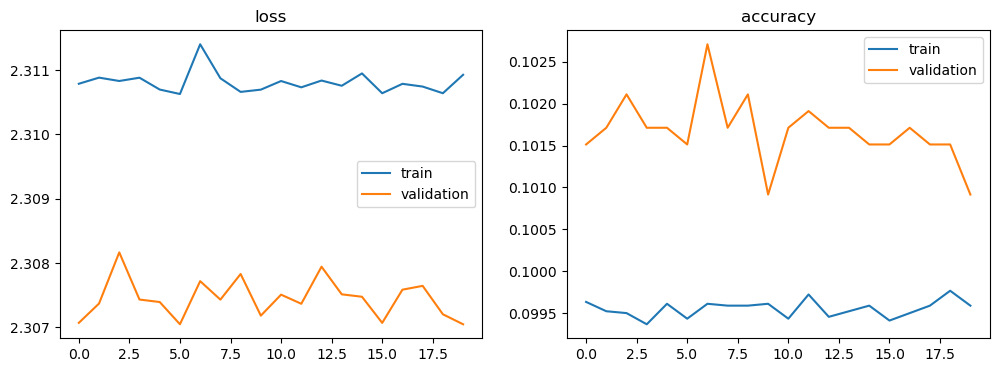

In [37]:
class LeNet(nn.Module):
    def __init__(self, in_channels, n_classes, dropout=0.5):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes   = n_classes

        self.conv1   = nn.Conv2d(in_channels  = self.in_channels,
                                 out_channels = 6,
                                 kernel_size  = 5,
                                 stride       = 2,
                                 padding      = 2,
                                 dilation     = 1)
        self.bn1 = nn.BatchNorm2d(6)

        conv2_1   = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3, padding = 1)
        conv2_2   = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Sequential(conv2_1, nn.ReLU(), conv2_2, nn.BatchNorm2d(16))

        conv3_1 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 1), padding = 1)
        conv3_2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (1, 3), padding = 1)
        self.conv3 = nn.Sequential(conv3_1, nn.ReLU(), conv3_2)

        conv1x1_1 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 1)
        conv3x3  = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding = 1)
        conv1x1_2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 1)
        self.main_block = nn.Sequential(conv1x1_1, nn.BatchNorm2d(16), nn.ReLU(), conv3x3, nn.BatchNorm2d(16), nn.ReLU(), conv1x1_2, nn.BatchNorm2d(32))

        depth_conv = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, groups = 16, padding = 1)
        point_conv = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 1)
        self.conv5 = nn.Sequential(depth_conv, nn.BatchNorm2d(32), nn.ReLU(), point_conv)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc_out = nn.Linear(in_features = 64, out_features = self.n_classes)

        self.stochastic_depth = torchvision.ops.StochasticDepth(p=dropout, mode="batch")

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv3(x)
        x = torch.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        h = self.main_block(x)
        x = x + self.stochastic_depth(h)
        x = torch.relu(x)

        x = self.conv5(x)
        x = torch.relu(x)

        x = self.gap(x)
        h = torch.flatten(x, 1)
        x = self.fc_out(h)
        return x

model = LeNet(3, 10, dropout=0.5)
summary(model, input_size=(1, 3, 32, 32))

EPOCHS = 20
train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)
best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()
    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)
    scheduler.step()
    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)
    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model_with_stochastic_depth.pt')
    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch % 2 == 1:
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch] * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch] * 100:.2f}%')

plot_results(train_loss, valid_loss, train_acc, valid_acc)

__3.__ Одной из современных альтернатив архитектурам трансформерам является использование т.н. блока `ConvNeXt`. Идея блока предполагает, что если взять свевртку с большим ядром,то можно получить тотже эффект обобщения, что и для слоя трансформер. Для того чтобы создать лучшую способность общать признаки в блоке используется `Depthwise Convolution`, а затем два слоя точечных сверток, первый из которых расширяет число карт признаков, а второй возвращает их число обратно.

[Одна из реализаций блок](https://github.com/vishhvak/ConvNeXt/blob/master/ConvNeXt.py) приведена ниже.

```python
    class ConvNeXtBlock(torch.nn.Module):
        def __init__(self, in_channels, out_channels, expansion_ratio = 2):
            super().__init__()
            hidden_dim = in_channels * expansion_ratio

            # Depthwise Convolution
            self.spatial_mixing = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, in_channels, kernel_size=7, padding=3, groups=in_channels),
                torch.nn.BatchNorm2d(in_channels)
            )

            # Pointwise Convolution, Upsampling Channels
            self.feature_mixing = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0),
                torch.nn.GELU(),
            )

            # Pointwise convolution, Downsampling Channels
            self.bottleneck = torch.nn.Sequential(
                torch.nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0)
        )

        def forward(self, x):
            out = self.spatial_mixing(x)
            out = self.feature_mixing(out)
            out = self.bottleneck(out)

            return x + out
```
__Предлагается__ изучить особенности данного слоя.

In [38]:
class ConvNeXtBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_ratio=2):
        super(ConvNeXtBlock, self).__init__()
        hidden_dim = in_channels * expansion_ratio


        self.spatial_mixing = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=7, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels)
        )

        self.feature_mixing = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0),
            nn.GELU(),
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        out = self.spatial_mixing(x)
        out = self.feature_mixing(out)
        out = self.bottleneck(out)

        return x + out

class ConvNeXtModel(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeXtModel, self).__init__()
        self.conv_next_block1 = ConvNeXtBlock(in_channels=3, out_channels=64)
        self.conv_next_block2 = ConvNeXtBlock(in_channels=64, out_channels=128)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_next_block1(x)
        x = self.conv_next_block2(x)
        x = x.mean(dim=[2, 3])
        x = self.fc(x)
        return x

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 41s
	Train Loss: 2.318 | Train Acc: 9.81%
	 Val. Loss: 2.312 |  Val. Acc: 9.06%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 41s
	Train Loss: 2.318 | Train Acc: 9.81%
	 Val. Loss: 2.310 |  Val. Acc: 8.80%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 41s
	Train Loss: 2.319 | Train Acc: 9.68%
	 Val. Loss: 2.310 |  Val. Acc: 8.98%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 41s
	Train Loss: 2.319 | Train Acc: 9.80%
	 Val. Loss: 2.312 |  Val. Acc: 8.84%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 41s
	Train Loss: 2.319 | Train Acc: 9.68%
	 Val. Loss: 2.313 |  Val. Acc: 9.24%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 52s
	Train Loss: 2.318 | Train Acc: 9.55%
	 Val. Loss: 2.310 |  Val. Acc: 8.90%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 44s
	Train Loss: 2.319 | Train Acc: 9.82%
	 Val. Loss: 2.309 |  Val. Acc: 8.90%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 44s
	Train Loss: 2.318 | Train Acc: 9.83%
	 Val. Loss: 2.311 |  Val. Acc: 8.94%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 45s
	Train Loss: 2.319 | Train Acc: 9.67%
	 Val. Loss: 2.316 |  Val. Acc: 9.65%


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 43s
	Train Loss: 2.318 | Train Acc: 9.64%
	 Val. Loss: 2.314 |  Val. Acc: 9.53%


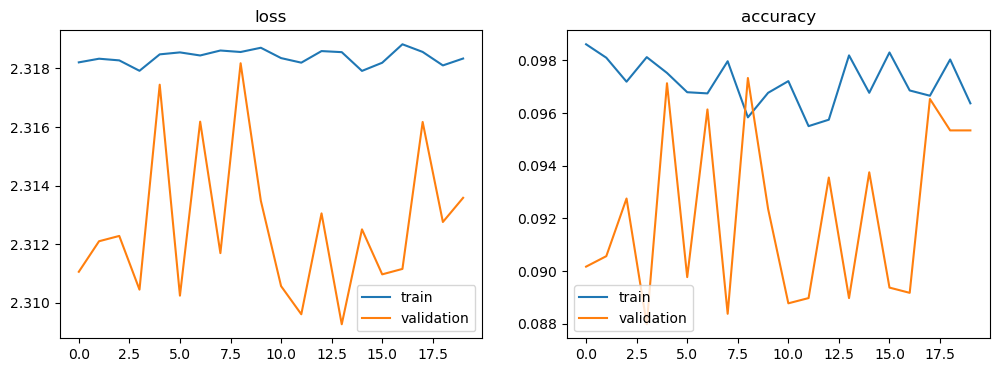

In [39]:
model = LeNet(3, 10, dropout=0.5)
summary(model, input_size=(1, 3, 32, 32))

EPOCHS = 20
train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)
best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()
    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)
    scheduler.step()
    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   validloader,
                                                   criterion,
                                                   metric,
                                                   device)
    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_convnext_model.pt')
    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch % 2 == 1:
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch] * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch] * 100:.2f}%')

plot_results(train_loss, valid_loss, train_acc, valid_acc)

__4.__ Часто к стандартным блокам сверточной сети добовляют блоки внимания, одна из самых простых реализаций такого блока, в тоже время одна из лучших реализаций блока - это `Squeeze and excitation block`. [Типичная структура](https://amaarora.github.io/posts/2020-07-24-SeNet.html) блока без использования остаточных связей показана ниже:
<img src="https://amaarora.github.io/images/senet_block.png" with="500px">

```python
    class SE_Block(nn.Module):
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze_pool = nn.AdaptiveAvgPool2d(1)
        
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze_pool(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)
```
В ряде случаев (см. например `EfficientNet`) в этом блоке вместо полносвязных слоев используются светочные слои. __Предлагаем__ проверить обе релаизации блока в архитектуре. 

/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 36s
	Train Loss: 1.889 | Train Acc: 28.81%
	 Val. Loss: 1.832 |  Val. Acc: 32.27%
Epoch: 04 | Epoch Time: 0m 35s
	Train Loss: 1.744 | Train Acc: 35.44%
	 Val. Loss: 1.738 |  Val. Acc: 37.12%
Epoch: 06 | Epoch Time: 0m 35s
	Train Loss: 1.658 | Train Acc: 39.23%
	 Val. Loss: 1.616 |  Val. Acc: 40.84%
Epoch: 08 | Epoch Time: 0m 35s
	Train Loss: 1.639 | Train Acc: 39.93%
	 Val. Loss: 1.620 |  Val. Acc: 40.96%
Epoch: 10 | Epoch Time: 0m 35s
	Train Loss: 1.632 | Train Acc: 40.03%
	 Val. Loss: 1.600 |  Val. Acc: 41.66%
Epoch: 12 | Epoch Time: 0m 35s
	Train Loss: 1.624 | Train Acc: 40.39%
	 Val. Loss: 1.599 |  Val. Acc: 42.04%
Epoch: 14 | Epoch Time: 0m 34s
	Train Loss: 1.622 | Train Acc: 40.63%
	 Val. Loss: 1.586 |  Val. Acc: 42.24%
Epoch: 16 | Epoch Time: 0m 33s
	Train Loss: 1.622 | Train Acc: 40.79%
	 Val. Loss: 1.619 |  Val. Acc: 41.42%
Epoch: 18 | Epoch Time: 0m 35s
	Train Loss: 1.620 | Train Acc: 40.73%
	 Val. Loss: 1.601 |  Val. Acc: 41.32%
Epoch: 20 | Epoch T

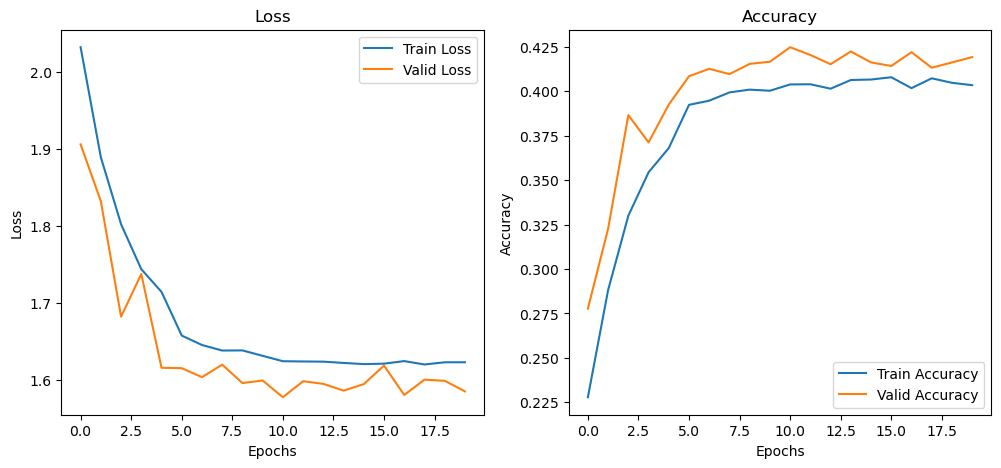

In [40]:
class SE_Block(nn.Module):
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze_pool = nn.AdaptiveAvgPool2d(1)

        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze_pool(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)


class LSE_Block(nn.Module):
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze_pool = nn.AdaptiveAvgPool2d(1)

        self.excitation = nn.Sequential(
            nn.Conv2d(c, c // r, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(c // r, c, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze_pool(x)
        y = self.excitation(y)
        return x * y

class LeNetWithSE(nn.Module):
    def __init__(self, in_channels, n_classes, dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.se1 = SE_Block(6)

        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16)
        )
        self.se2 = SE_Block(16)

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 1), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(1, 3), padding=1)
        )
        self.se3 = SE_Block(32)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_out = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.se1(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.se2(x)

        x = self.conv3(x)
        x = torch.relu(x)
        x = self.se3(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc_out(x)
        return x

class LeNetWithLSE(nn.Module):
    def __init__(self, in_channels, n_classes, dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.lse1 = LSE_Block(6)

        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16)
        )
        self.lse2 = LSE_Block(16)

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 1), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(1, 3), padding=1)
        )
        self.lse3 = LSE_Block(32)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_out = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.lse1(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.lse2(x)

        x = self.conv3(x)
        x = torch.relu(x)
        x = self.lse3(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc_out(x)
        return x

def train(model, trainloader, optimizer, criterion, metric, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += metric(output, target)

    return epoch_loss / len(trainloader), epoch_acc / len(trainloader)

def evaluate(model, validloader, criterion, metric, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for data, target in validloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_loss += loss.item()
            epoch_acc += metric(output, target)

    return epoch_loss / len(validloader), epoch_acc / len(validloader)

def plot_results(train_loss, valid_loss, train_acc, valid_acc):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Valid Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(valid_acc, label='Valid Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

model = LeNetWithSE(3, 10, dropout=0.5)
summary(model, input_size=(1, 3, 32, 32))

EPOCHS = 20
train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc = torch.zeros(EPOCHS)
valid_acc = torch.zeros(EPOCHS)
best_valid_loss = float('inf')
best_epoch = 0

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()
    train_loss[epoch], train_acc[epoch] = train(model, trainloader, optimizer, criterion, metric, device)
    scheduler.step()
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, validloader, criterion, metric, device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model_with_se.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch % 2 == 1:
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch] * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch] * 100:.2f}%')

plot_results(train_loss, valid_loss, train_acc, valid_acc)

__5.__ Одна из наиболее удачных архитектур сверточных сетей - это `ResNet`. Типичная структура ResNet предполагает:
* входной блок (`steam`), реализуемый слоем с большим ядром и большим шагом, а также слой пулинга.
* 5 Блоки т.н. тела, каждый из блоков состоит из нескольких bottleneck слоев. Внутри блока разменость карты признаков и число каналов сохраняются.
* Глобальный средний пулинг.
* слой принятия решений.
* Если в bottleneck слое происходит сжатие размерности, то слой имеет шаг 2 в основной части и может быть дополнен сверткой $1\times 1$ с нужным шагом в остаточной части.
* Каждая свертка сопровождается батч-нормализацией и функцией активации ReLU.
Иллюстрация приведена ниже, простую реализацию можно найти, например [тут](https://github.com/Lightning-AI/dl-fundamentals/blob/main/unit07-computer-vision/7.4-cnn-training/7.4-part-4-resnet-scratch.ipynb) и [тут](https://d2l.ai/chapter_convolutional-modern/resnet.html)

<img src="https://pytorch.org/assets/images/resnet.png" width="900px">


__Предлагается__ реализовать уменьшенную копию архитектуры `ResNet`, например [`ResNet9`](https://github.com/VanekPetr/ResNet-9/blob/main/model.py)


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 42s
	Train Loss: 2.451 | Train Acc: 10.44%
	 Val. Loss: 2.431 |  Val. Acc: 10.57%


Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 38s
	Train Loss: 2.448 | Train Acc: 10.47%
	 Val. Loss: 2.434 |  Val. Acc: 10.47%


Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 36s
	Train Loss: 2.448 | Train Acc: 10.67%
	 Val. Loss: 2.434 |  Val. Acc: 10.53%


Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 37s
	Train Loss: 2.449 | Train Acc: 10.46%
	 Val. Loss: 2.431 |  Val. Acc: 10.59%


Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 36s
	Train Loss: 2.449 | Train Acc: 10.43%
	 Val. Loss: 2.431 |  Val. Acc: 10.57%


Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 35s
	Train Loss: 2.449 | Train Acc: 10.49%
	 Val. Loss: 2.440 |  Val. Acc: 10.49%


Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 35s
	Train Loss: 2.449 | Train Acc: 10.39%
	 Val. Loss: 2.429 |  Val. Acc: 10.49%


Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 38s
	Train Loss: 2.448 | Train Acc: 10.52%
	 Val. Loss: 2.433 |  Val. Acc: 10.49%


Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 41s
	Train Loss: 2.451 | Train Acc: 10.56%
	 Val. Loss: 2.428 |  Val. Acc: 10.67%


Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training :   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 43s
	Train Loss: 2.448 | Train Acc: 10.34%
	 Val. Loss: 2.433 |  Val. Acc: 10.55%


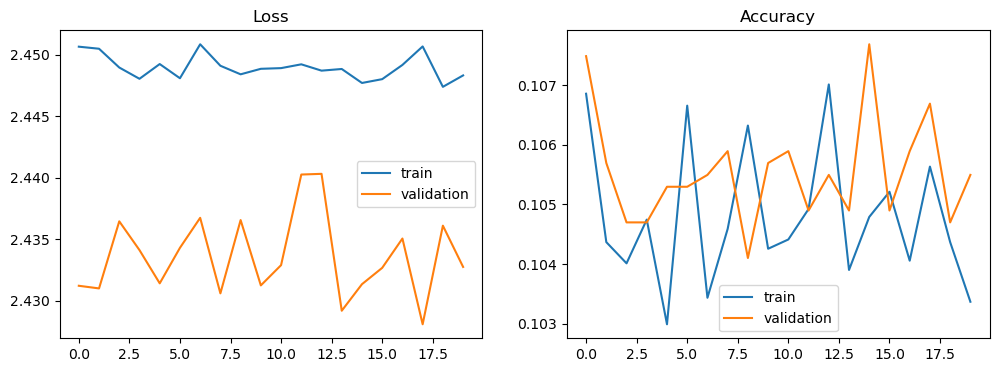

In [41]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 4)
        self.conv2 = nn.Conv2d(out_channels // 4, out_channels // 4, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels // 4)
        self.conv3 = nn.Conv2d(out_channels // 4, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = nn.ReLU()(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, stride=1):
        super(ResNetBlock, self).__init__()
        layers = []
        layers.append(Bottleneck(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(Bottleneck(out_channels, out_channels))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = ResNetBlock(16, 32, num_blocks=2, stride=1)
        self.layer2 = ResNetBlock(32, 64, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def train(model, dataloader, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in tqdm(dataloader, desc="Training ", leave=False):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = (y_pred.argmax(1) == y).float().mean()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = (y_pred.argmax(1) == y).float().mean()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def plot_results(train_loss, valid_loss, train_acc, valid_acc):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(train_loss.cpu().numpy(), label='train')
    axs[0].plot(valid_loss.cpu().numpy(), label='validation')
    axs[0].set_title('Loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label='train')
    axs[1].plot(valid_acc.cpu().numpy(), label='validation')
    axs[1].set_title('Accuracy')
    axs[1].legend()
    plt.show()

model = ResNet9(num_classes=10).to(device)
summary(model, input_size=(1, 3, 32, 32))

EPOCHS = 20
train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc = torch.zeros(EPOCHS)
valid_acc = torch.zeros(EPOCHS)
best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()
    train_loss[epoch], train_acc[epoch] = train(model, trainloader, optimizer, criterion, device)
    scheduler.step()
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, validloader, criterion, device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_resnet9_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch % 2 == 1:
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch] * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch] * 100:.2f}%')
plot_results(train_loss, valid_loss, train_acc, valid_acc)

__6.__ В структуру блоков `ResNet` часто пытаются внести изменения с целью улучшить качество работы архитекутры. Одна из первых попыток такого улучшения - это архитектура `ResNeXt`, иллюстрация которой приведена ниже.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_4.32.52_PM.png" width="700px"> 

__Предлагается__ модифицировать описанную архитектуру `ResNet` в соотвествии с идеей `ResNeXt`.

In [42]:
class ResNeXtBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cardinality=32, stride=1):
        super(ResNeXtBlock, self).__init__()
        self.cardinality = cardinality
        self.out_channels = out_channels

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 44s
	Train Loss: 1.754 | Train Acc: 36.32%
	 Val. Loss: 1.567 |  Val. Acc: 43.89%
Epoch: 04 | Epoch Time: 0m 39s
	Train Loss: 1.582 | Train Acc: 43.46%
	 Val. Loss: 1.475 |  Val. Acc: 47.41%
Epoch: 06 | Epoch Time: 0m 44s
	Train Loss: 1.454 | Train Acc: 48.57%
	 Val. Loss: 1.331 |  Val. Acc: 52.65%
Epoch: 08 | Epoch Time: 0m 44s
	Train Loss: 1.425 | Train Acc: 49.48%
	 Val. Loss: 1.316 |  Val. Acc: 53.14%
Epoch: 10 | Epoch Time: 0m 39s
	Train Loss: 1.406 | Train Acc: 50.36%
	 Val. Loss: 1.330 |  Val. Acc: 53.22%
Epoch: 12 | Epoch Time: 0m 38s
	Train Loss: 1.401 | Train Acc: 50.45%
	 Val. Loss: 1.306 |  Val. Acc: 53.44%
Epoch: 14 | Epoch Time: 0m 42s
	Train Loss: 1.400 | Train Acc: 50.28%
	 Val. Loss: 1.310 |  Val. Acc: 53.78%
Epoch: 16 | Epoch Time: 0m 41s
	Train Loss: 1.393 | Train Acc: 50.85%
	 Val. Loss: 1.333 |  Val. Acc: 53.32%
Epoch: 18 | Epoch Time: 0m 39s
	Train Loss: 1.394 | Train Acc: 50.68%
	 Val. Loss: 1.309 |  Val. Acc: 54.14%
Epoch: 20 | Epoch T

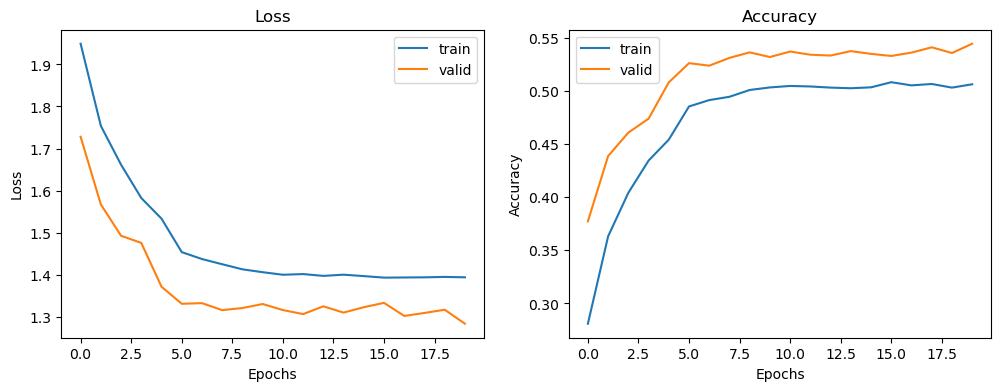

In [43]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride=stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = ResNet9(num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 20
train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc = torch.zeros(EPOCHS)
valid_acc = torch.zeros(EPOCHS)
best_valid_loss = float('inf')
best_epoch = 0

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for (x, y) in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        acc = (y_pred.argmax(dim=1) == y).float().mean()
        epoch_acc += acc.item()
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()
            acc = (y_pred.argmax(dim=1) == y).float().mean()
            epoch_acc += acc.item()
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()
    train_loss[epoch], train_acc[epoch] = train(model, trainloader, optimizer, criterion, device)
    scheduler.step()
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, validloader, criterion, device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_resnet9_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch % 2 == 1:
        print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch] * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch] * 100:.2f}%')

def plot_results(train_loss, valid_loss, train_acc, valid_acc):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(train_loss.cpu().numpy(), label='train')
    axs[0].plot(valid_loss.cpu().numpy(), label='valid')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(train_acc.cpu().numpy(), label='train')
    axs[1].plot(valid_acc.cpu().numpy(), label='valid')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

plot_results(train_loss, valid_loss, train_acc, valid_acc)